# Breast Cancer Dataset


Sigmoid function output with and without SMOTE

C:\Users\Public\anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Public\anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Public\anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Public\anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(


with SMOTE

true positives: 64 
true negatives: 16 
false positives: 90 
false negatives: 1 
precision: 0.4155844155844156 
recall: 0.9846153846153847 
F score of the network: 0.5844748858447488 

without SMOTE

true positives: 56 
true negatives: 43 
false positives: 63 
false negatives: 9 
precision: 0.47058823529411764 
recall: 0.8615384615384616 
F score of the network: 0.608695652173913 


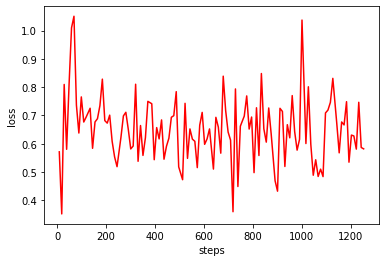

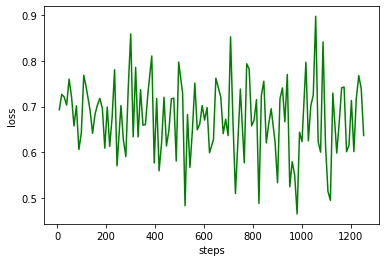

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(10)




# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#loading and cleaning data

data=pd.read_csv('data.csv')#dataframe

data=data[['diagnosis', 'radius_mean', 'texture_mean','fractal_dimension_mean']]#reduced dataframe

data['diagnosis'].replace({'B':0, 'M':1}, inplace = True)#all data is now numerical

data=torch.tensor(data.values)# dataframe to tensor

#shuffling the data so that training and validation set have uniform distribution
data=data[torch.randperm(data.size()[0])]

X=data[:,1:]#all rows but only first 3 columns
y=data[:,0]#all rows but only last column that has the label


from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.int())

X_train_res = torch.tensor(X_train_res)
y_train_res = torch.tensor(y_train_res)



#training test and test set:

l=data.shape[0]

# division


y_train=y_train_res.long()#convert to long
y_test=y_test.long()#convert to long

train_ds = torch.utils.data.TensorDataset(X_train_res, y_train)#create dataset

valid_ds = torch.utils.data.TensorDataset(X_test, y_test)




# Hyper-parameters 
input_size = 3
hidden_size1 = 256
hidden_size2 = 16
num_classes = 2#number of unique classes
num_epochs = 10
bs = 4
learning_rate = 0.001


train_dl = torch.utils.data.DataLoader(dataset=train_ds, 
                                           batch_size=bs, 
                                           shuffle=True)#create data loader: loads data in batches

valid_dl = torch.utils.data.DataLoader(dataset=valid_ds, 
                                           batch_size=bs, 
                                           shuffle=False)




# Fully connected neural network 
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.softmax(out)
        
        return out

model = NeuralNet(input_size, hidden_size1, hidden_size2, num_classes).to(device) # calls the constructor function when an object is created

# Loss and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

losses1=[]
steps=[]

# Train the model
total_step = len(train_dl)
for epoch in range(num_epochs):
    for i, (xb, yb) in enumerate(train_dl):  
        
        # Move tensors to the configured device
        xb = xb.to(device)
        yb = yb.to(device)#target labels
        
        # Forward pass
        outputs = model(xb.float())
        loss = loss_func(outputs, yb)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
           # print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            #       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            losses1.append(loss.item())
            steps.append(epoch*total_step+i)
            
            


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():

    
    #for F score
    tp1=0
    tn1=0
    fp1=0
    fn1=0
    
    for xb, yb in valid_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        outputs = model(xb.float())
        _, predicted = torch.max(outputs.data, 1)
        
        

        
        tp1 += ((predicted==1)*(yb==1)).sum().item()
        tn1 += ((predicted==0)*(yb==0)).sum().item()
        fp1 += ((predicted==1)*(yb==0)).sum().item()
        fn1 += ((predicted==0)*(yb==1)).sum().item()

        
    
    
    p1=tp1/(tp1+fp1)
    r1=tp1/(tp1+fn1)
    
    print("\nwith SMOTE\n")
    print('true positives: {} '.format(tp1))
    print('true negatives: {} '.format(tn1))
    print('false positives: {} '.format(fp1))
    print('false negatives: {} '.format(fn1))
    print('precision: {} '.format(p1))
    print('recall: {} '.format(r1))
    
    fsc1=2*p1*r1/(p1+r1)
    
    print('F score of the network: {} '.format(fsc1))
    
# Device configuration

#loading and cleaning data
#training test and test set:

l=data.shape[0]

# division

l=7*l//10 #70% data for training

train=data[:l]
test=data[l:]

x_train=train[:,1:]#all rows but only last 3 columns
y_train=train[:,0]#all rows but only first column that has the label

x_test=test[:,1:]#all rows but only first 3 columns
y_test=test[:,0]#all rows but only last column that has the label

y_train=y_train.long()#convert to long
y_test=y_test.long()#convert to long

train_ds = torch.utils.data.TensorDataset(x_train, y_train)#create dataset

valid_ds = torch.utils.data.TensorDataset(x_test, y_test)


model = NeuralNet(input_size, hidden_size1, hidden_size2, num_classes).to(device) # calls the constructor function when an object is created

# Loss and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

losses2=[]

# Train the model
total_step = len(train_dl)
for epoch in range(num_epochs):
    for i, (xb, yb) in enumerate(train_dl):  
        
        # Move tensors to the configured device
        xb = xb.to(device)
        yb = yb.to(device)#target labels
        
        # Forward pass
        outputs = model(xb.float())
        loss = loss_func(outputs, yb)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
           # print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            #       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            losses2.append(loss.item())
            
            
            


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():

    
    #for F score
    tp2=0
    tn2=0
    fp2=0
    fn2=0
    
    for xb, yb in valid_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        outputs = model(xb.float())
        _, predicted = torch.max(outputs.data, 1)
        
        

        
        tp2 += ((predicted==1)*(yb==1)).sum().item()
        tn2 += ((predicted==0)*(yb==0)).sum().item()
        fp2 += ((predicted==1)*(yb==0)).sum().item()
        fn2 += ((predicted==0)*(yb==1)).sum().item()

        
    
    p2=tp2/(tp2+fp2)
    r2=tp2/(tp2+fn2)
    
    print("\nwithout SMOTE\n")
    print('true positives: {} '.format(tp2))
    print('true negatives: {} '.format(tn2))
    print('false positives: {} '.format(fp2))
    print('false negatives: {} '.format(fn2))
    print('precision: {} '.format(p2))
    print('recall: {} '.format(r2))
    
    fsc2=2*p2*r2/(p2+r2)
    
    print('F score of the network: {} '.format(fsc2))

    
plt.plot(steps, losses1, 'r')
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()

plt.plot(steps, losses2, 'g')
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()



# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')



C:\Users\Public\anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Public\anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Public\anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Public\anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach(


with SMOTE

true positives: 178 
true negatives: 140 
false positives: 283 
false negatives: 80 
precision: 0.38611713665943603 
recall: 0.689922480620155 
F score of the network: 0.49513212795549366 

without SMOTE

true positives: 98 
true negatives: 274 
false positives: 149 
false negatives: 160 
precision: 0.3967611336032389 
recall: 0.3798449612403101 
F score of the network: 0.3881188118811882 


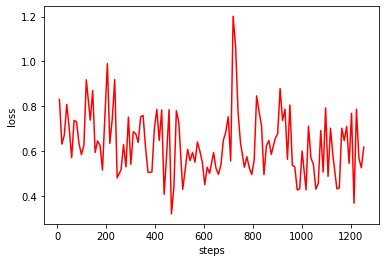

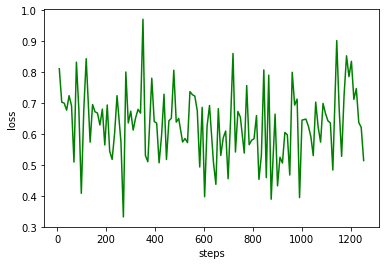

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(10)



# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#loading and cleaning data

data=pd.read_csv('data.csv')#dataframe

data=data[['diagnosis', 'radius_mean', 'texture_mean','fractal_dimension_mean']]#reduced dataframe

data['diagnosis'].replace({'B':0, 'M':1}, inplace = True)#all data is now numerical

data=torch.tensor(data.values)# dataframe to tensor

#shuffling the data so that training and validation set have uniform distribution
data=data[torch.randperm(data.size()[0])]

X=data[:,1:]#all rows but only first 3 columns
y=data[:,0]#all rows but only last column that has the label


from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.int())

X_train_res = torch.tensor(X_train_res)
y_train_res = torch.tensor(y_train_res)



#training test and test set:

l=data.shape[0]

# division


y_train=y_train_res.long()#convert to long
y_test=y_test.long()#convert to long

train_ds = torch.utils.data.TensorDataset(X_train_res, y_train)#create dataset

valid_ds = torch.utils.data.TensorDataset(X_test, y_test)




# Hyper-parameters 
input_size = 3
hidden_size1 = 256
hidden_size2 = 16
num_classes = 2#number of unique classes
num_epochs = 10
bs = 4
learning_rate = 0.001
threshold=0.5


train_dl = torch.utils.data.DataLoader(dataset=train_ds, 
                                           batch_size=bs, 
                                           shuffle=True)#create data loader: loads data in batches

valid_dl = torch.utils.data.DataLoader(dataset=valid_ds, 
                                           batch_size=bs, 
                                           shuffle=False)




# Fully connected neural network 
class NeuralNet2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(NeuralNet2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        
        return out

model = NeuralNet2(input_size, hidden_size1, hidden_size2).to(device) # calls the constructor function when an object is created

# Loss and optimizer
loss_func = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

losses1=[]
steps=[]

# Train the model
total_step = len(train_dl)
for epoch in range(num_epochs):
    for i, (xb, yb) in enumerate(train_dl):  
        
        # Move tensors to the configured device
        xb = xb.to(device)
        yb = yb.to(device)#target labels
        
        # Forward pass
        outputs = model(xb.float())
        loss = loss_func(outputs.float(), yb.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
           # print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            #       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            losses1.append(loss.item())
            steps.append(epoch*total_step+i)
            
            


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():

    
    #for F score
    tp1=0
    tn1=0
    fp1=0
    fn1=0
    
    for xb, yb in valid_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        outputs = model(xb.float())
        #_, predicted = torch.max(outputs.data, 1)
        
        predicted = outputs>=threshold
        
        

        
        tp1 += ((predicted==1)*(yb==1)).sum().item()
        tn1 += ((predicted==0)*(yb==0)).sum().item()
        fp1 += ((predicted==1)*(yb==0)).sum().item()
        fn1 += ((predicted==0)*(yb==1)).sum().item()

        
    
    
    p1=tp1/(tp1+fp1)
    r1=tp1/(tp1+fn1)
    
    print("\nwith SMOTE\n")
    print('true positives: {} '.format(tp1))
    print('true negatives: {} '.format(tn1))
    print('false positives: {} '.format(fp1))
    print('false negatives: {} '.format(fn1))
    print('precision: {} '.format(p1))
    print('recall: {} '.format(r1))
    
    fsc1=2*p1*r1/(p1+r1)
    
    print('F score of the network: {} '.format(fsc1))
    
# Device configuration

#loading and cleaning data
#training test and test set:

l=data.shape[0]

# division

l=7*l//10 #70% data for training

train=data[:l]
test=data[l:]

x_train=train[:,1:]#all rows but only last 3 columns
y_train=train[:,0]#all rows but only first column that has the label

x_test=test[:,1:]#all rows but only first 3 columns
y_test=test[:,0]#all rows but only last column that has the label

y_train=y_train.long()#convert to long
y_test=y_test.long()#convert to long

train_ds = torch.utils.data.TensorDataset(x_train, y_train)#create dataset

valid_ds = torch.utils.data.TensorDataset(x_test, y_test)


model = NeuralNet2(input_size, hidden_size1, hidden_size2).to(device) # calls the constructor function when an object is created

# Loss and optimizer
loss_func = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

losses2=[]

# Train the model
total_step = len(train_dl)
for epoch in range(num_epochs):
    for i, (xb, yb) in enumerate(train_dl):  
        
        # Move tensors to the configured device
        xb = xb.to(device)
        yb = yb.to(device)#target labels
        
        # Forward pass
        outputs = model(xb.float())
        loss = loss_func(outputs.float(), yb.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
           # print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            #       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            losses2.append(loss.item())
            
            
            


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():

    
    #for F score
    tp2=0
    tn2=0
    fp2=0
    fn2=0
    
    for xb, yb in valid_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        outputs = model(xb.float())
        #_, predicted = torch.max(outputs.data, 1)
        
        predicted = outputs>=threshold
        
        

        
        tp2 += ((predicted==1)*(yb==1)).sum().item()
        tn2 += ((predicted==0)*(yb==0)).sum().item()
        fp2 += ((predicted==1)*(yb==0)).sum().item()
        fn2 += ((predicted==0)*(yb==1)).sum().item()

        
    
    p2=tp2/(tp2+fp2)
    r2=tp2/(tp2+fn2)
    
    print("\nwithout SMOTE\n")
    print('true positives: {} '.format(tp2))
    print('true negatives: {} '.format(tn2))
    print('false positives: {} '.format(fp2))
    print('false negatives: {} '.format(fn2))
    print('precision: {} '.format(p2))
    print('recall: {} '.format(r2))
    
    fsc2=2*p2*r2/(p2+r2)
    
    print('F score of the network: {} '.format(fsc2))

    
plt.plot(steps, losses1, 'r')
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()

plt.plot(steps, losses2, 'g')
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()



# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

